# Elektronska fiskalizacija

**Primjeri kod-a u Python-u**

Za primjere u prilogu je neophodno imati `signxml`, `pycrypto` pa to valja prethodno instalirati (`!pip install signxml pycrypto`). Osim toga, podrazumijeva se posjedovanje test PFX sertifikata (_CoreitPecatSoft.pfx_) u lokalnom folderu.

**sstevan**: Možete pokrenuti i `pip install -r requirements.txt ` da se instaliraju svi neophodni paketi.


In [1]:
pfx_cert = 'CoreitPecatSoft.pfx'
pfx_password = b'123456'

### Priprema sertifikata

Ekstrakcija privatnog kljuca i sertifikata iz PFX kontejnera. Za taj dio koristim kod dostupan na sljedecem [linku](https://www.jhanley.com/google-cloud-extracting-private-key-from-service-account-p12-credentials/) 

In [2]:
import OpenSSL.crypto
import os

###########################################################    
# Version 1.00
# Date Created: 2018-12-21
# Last Update:  2018-12-21
# https://www.jhanley.com
# Copyright (c) 2018, John J. Hanley
# Author: John Hanley
###########################################################

# Convert a Google P12 (PFX) service account into private key and certificate.
# Convert an SSL Certifcate (PFX) into private key, certificate and CAs.

def write_CAs(filename, p12):
    # Write the Certificate Authorities, if any, to filename

    if os.path.exists(filename):
        os.remove(filename)

    ca = p12.get_ca_certificates()

    if ca is None:
        return

    print('Creating Certificate CA File:', filename)

    with open(filename, 'wb') as f:
        for cert in ca:
            f.write(OpenSSL.crypto.dump_certificate(OpenSSL.crypto.FILETYPE_PEM, cert))

def pfx_to_pem(pfx_path, pfx_password, pkey_path, pem_path, pem_ca_path):
    '''
    Decrypt the P12 (PFX) file and create a private key file and certificate file.

    Input:
        pfx_path    INPUT: This is the Google P12 file or SSL PFX certificate file
        pfx_password    INPUT: Password used to protect P12 (PFX)
        pkey_path   INPUT: File name to write the Private Key to
        pem_path    INPUT: File name to write the Certificate to
        pem_ca_path INPUT: File name to write the Certificate Authorities to
    '''

    print('Opening:', pfx_path)
    with open(pfx_path, 'rb') as f_pfx:
        pfx = f_pfx.read()

    print('Loading P12 (PFX) contents:')
    p12 = OpenSSL.crypto.load_pkcs12(pfx, pfx_password)

    print('Creating Private Key File:', pkey_path)
    with open(pkey_path, 'wb') as f:
        # Write Private Key
        f.write(OpenSSL.crypto.dump_privatekey(OpenSSL.crypto.FILETYPE_PEM, p12.get_privatekey()))

    print('Creating Certificate File:', pem_path)
    with open(pem_path, 'wb') as f:
        # Write Certificate
        f.write(OpenSSL.crypto.dump_certificate(OpenSSL.crypto.FILETYPE_PEM, p12.get_certificate()))

    # Google P12 does not have certifiate authorities but SSL PFX certificates do
    write_CAs(pem_ca_path, p12)


# Start here
pfx_to_pem(
    pfx_cert,         # Google Service Account P12 file
    pfx_password,     # P12 file password
    'coreit.key',      # Filename to write private key
    'coreit_cert.pem', # Filename to write certificate
    'coreit_ca.pem')   # Filename to write CAs if present

Opening: CoreitPecatSoft.pfx
Loading P12 (PFX) contents:
Creating Private Key File: coreit.key
Creating Certificate File: coreit_cert.pem
Creating Certificate CA File: coreit_ca.pem


### Osnovi podaci

In [3]:
taxpayer = {
    'tin': '12345678', # Taxpayers tax identification number (PIB/JMB),
    'bu': 'xx123xx123', # Business unit code (PJ),
    'cr': 'si747we972', # ENU code,
    'sw': 'ss123ss123' # ENU software code
}

invoice = {
    'ord': '1', # Invoice ordinal number,
    'prc': '121.00' # Total invoice price / bice reazurirano
}

#### Stavke racuna

In [4]:
import pandas as pd
invoice_items = pd.DataFrame({
    'N': [], # Name of item (goods or services)
    'C': [], # Code of the item from the barcode or similar representation
    'U': [], # Unit of measure
    'Q': [], # Quantity
    'UPB': [], # Unit price before VAT is applied
    'UPA': [], # Unit price after VAT is applied
    'R': [], # Percentage of the rebate
    'RR': [], # Is rebate reducing tax base amount? (true)
    'PB': [], # Total price of goods and services before the tax
    'VR': [], # VAT Rate
    'VA': [], # Amount of VAT for goods and services
    'PA': [], # Price after applying VAT
})

invoice_items = invoice_items.append({
    'N': 'Test artikal',
    'C': '1234234',
    'U': 'kom',
    'Q': 1,
    'UPB': 100.0,
    'UPA': None,
    'R': 0,
    'RR': 'true',
    'PB': None,
    'VR': 21.00,
    'VA': None,
    'PA': None
}, ignore_index=True)


invoice_items['UPA'] = invoice_items['UPB'] * (1 + invoice_items['VR'] / 100)
invoice_items['PB'] = invoice_items['UPB'] * invoice_items['Q']
invoice_items['PA'] = invoice_items['UPA'] * invoice_items['Q']
invoice_items['VA'] = invoice_items['PA'] - invoice_items['PB']
invoice_items

,N,C,U,Q,UPB,UPA,R,RR,PB,VR,VA,PA
0,Test artikal,1234234,kom,1.0,100.0,121.0,0.0,true,100.0,21.0,21.0,121.0


In [5]:
# TODO: Spojiti stavke fakture sa XML dokumentom (to cu kad stignem :D)

#### Generisanje UUID-a

In [6]:
import uuid
fresh_uuid = str(uuid.uuid4())

#### Odredjivanje datuma i vremena

In [7]:
from datetime import datetime
import pytz

current_time = datetime.now(pytz.timezone('Europe/Podgorica')).strftime('%Y-%m-%dT%H:%M:%S%z')
current_time = "{0}:{1}".format(current_time[:-2], current_time[-2:])

### Generisanje IKOF-a

In [8]:
import hashlib
import sys
import time

from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_v1_5 as Cipher_PKCS1_v1_5
from Crypto.Signature import PKCS1_v1_5
from base64 import b64decode, b64encode
from Crypto.Hash import SHA256

# sstevan: Python 3.8 nema time.clock() pa pycrypto pravi probleme
if sys.version_info >= (3, 8):
    time.clock = time.process_time


def generate_iis(data, private_key_path):
    print('IKOF data element:', data)
    message = bytes(data, 'utf8')
    digest = SHA256.new()
    digest.update(message)    
    private_key = False
    with open(private_key_path, "r") as key_file:
        private_key = RSA.importKey(key_file.read())
    signer = PKCS1_v1_5.new(private_key)
    sig = signer.sign(digest)
    iic = hashlib.md5(sig).digest()
    
    return (sig.hex(), iic.hex())

#### Primjer:

In [9]:
(iic, ikof) = generate_iis(
    "{tin}|{current_time}|{no}|{bu}|{cr}|{sw}|{prc}".format(
        tin = taxpayer['tin'],
        current_time = current_time,
        no = invoice['ord'],
        bu = taxpayer['bu'],
        cr = taxpayer['cr'],
        sw = taxpayer['sw'],
        prc = invoice['prc']
    ),
    'coreit.key'
)
print("IKOF:", ikof)

IKOF data element: 12345678|2020-12-29T12:58:19+01:00|1|xx123xx123|si747we972|ss123ss123|121.00
IKOF: 5317e84aba9999d39f7743f631109d16


### Priprema i potpisivanje XML-a

#### Priprema XML objekta i parsiranje XML sadrzaja

In [10]:
# Formiranje dictionary objekta sa podacima za XML fajl
xmldata = {
    'RegisterInvoiceRequest': {
        '@xmlns:xsd': 'http://www.w3.org/2001/XMLSchema',
        '@xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
        '@xmlns': 'https://efi.tax.gov.me/fs/schema',
        '@Id': 'Request',
        '@Version': '1',
        'Header': {
            '@UUID': fresh_uuid,
            '@SendDateTime': current_time
        },
        'Invoice': {
            '@TypeOfInv': 'NONCASH',
            '@IsSimplifiedInv': 'false',
            '@IssueDateTime': current_time,
            '@InvNum': '{0}/{1}/{2}/{3}'.format(taxpayer['bu'], invoice['ord'], datetime.now().year, taxpayer['cr']),
            '@InvOrdNum': invoice['ord'],
            '@TCRCode': taxpayer['cr'], # ENU code
            '@IsIssuerInVAT': 'true',
            '@TotPriceWoVAT': '100.00',
            '@TotVATAmt': '21.00',
            '@TotPrice': '121.00',
            '@OperatorCode': 'oo123oo123',
            '@BusinUnitCode': taxpayer['bu'],
            '@SoftCode': 'ss123ss123',
            '@IIC': ikof,
            '@IICSignature': iic,
            '@IsReverseCharge': 'false',
            'PayMethods': {
                'PayMethod': {
                    '@Type': 'ACCOUNT',
                    '@Amt': '121.00'
                }
            },
            'Seller': {
                '@IDType': 'TIN',
                '@IDNum': '12345678',
                '@Name': 'Test d.o.o.'
            },
            'Buyer': {
                '@IDType': 'TIN',
                '@IDNum': '12345678',
                '@Name': 'Test d.o.o'
            },
            'Items': {
                'I': {
                    '@N': 'Test artikal',
                    '@C': '1234234',
                    '@U': 'kom',
                    '@Q': '1',
                    '@UPB': '100.00',
                    '@UPA': '121.00',
                    '@R': '0',
                    '@RR': 'true',
                    '@PB': '100.00',
                    '@VR': '21.00',
                    '@VA': '21.00',
                    '@PA': '121.00'
                }
            },
            'SameTaxes': {
                'SameTax': {
                    '@NumOfItems': '1',
                    '@PriceBefVAT': '100.00',
                    '@VATRate': '21.00',
                    '@VATAmt': '21.00'
                }
            }
        }
    }
}

In [11]:
# Konverzija u XML format za parsiranje u etree objekat
import xmltodict
xml = xmltodict.unparse(xmldata)

# etree ne voli encoding zapis, pa se on uklanja iz XML-a
xml = xml.replace(' encoding="utf-8"', '')

from lxml import etree
xml_obj = etree.fromstring(xml)

In [12]:
print(etree.tostring(xml_obj, encoding='utf8').decode('utf8'))

<RegisterInvoiceRequest xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns="https://efi.tax.gov.me/fs/schema" Id="Request" Version="1"><Header UUID="14db9b5d-d702-45fb-be84-6f4ded25e68c" SendDateTime="2020-12-29T12:58:19+01:00"/><Invoice TypeOfInv="NONCASH" IsSimplifiedInv="false" IssueDateTime="2020-12-29T12:58:19+01:00" InvNum="xx123xx123/1/2020/si747we972" InvOrdNum="1" TCRCode="si747we972" IsIssuerInVAT="true" TotPriceWoVAT="100.00" TotVATAmt="21.00" TotPrice="121.00" OperatorCode="oo123oo123" BusinUnitCode="xx123xx123" SoftCode="ss123ss123" IIC="5317e84aba9999d39f7743f631109d16" IICSignature="77791d08057c9d9998c88b5ab3a3c0db89b35228f74a741c3cfdb609fc110b909373957deacb020cebed8fe70691ad36197f57098200d6e59f52290b391348270dfcc9adbd051d00f4354568874b9850c3e3917003e39c84b403f59536e353af77d9acf0fdd41e6fba333f8c3d910552674cdc91972bf0bdf235901b52ad4db08987f593e05aa2d19c305c54844ee41ec10f88340e01981c97eacedf76d87ab3b1d044b8f61ca7663e80a

#### Potpisivanje

In [13]:
from lxml import etree
from signxml import XMLSigner, XMLVerifier, methods

cert = open("coreit_cert.pem", 'rb').read()
key = open("coreit.key", 'rb').read()

signer = XMLSigner(
    method = methods.enveloped,
    signature_algorithm = 'rsa-sha256',
    digest_algorithm = 'sha256',
    c14n_algorithm = 'http://www.w3.org/2001/10/xml-exc-c14n#'
)

# Uklanjanje suvisnih DS namespace prefix-a prema preporuci sa: 
# https://github.com/XML-Security/signxml/issues/30#issuecomment-149618525
ns = {}
ns[None] = signer.namespaces['ds']
signer.namespaces = ns

# Konacno potpisivanje
signed_xml = signer.sign(
    xml_obj, 
    key=key,
    cert=cert
)

#### Rezultat

In [14]:
print(etree.tostring(signed_xml, encoding='utf8').decode('utf8'))

<RegisterInvoiceRequest xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns="https://efi.tax.gov.me/fs/schema" Id="Request" Version="1"><Header UUID="14db9b5d-d702-45fb-be84-6f4ded25e68c" SendDateTime="2020-12-29T12:58:19+01:00"/><Invoice TypeOfInv="NONCASH" IsSimplifiedInv="false" IssueDateTime="2020-12-29T12:58:19+01:00" InvNum="xx123xx123/1/2020/si747we972" InvOrdNum="1" TCRCode="si747we972" IsIssuerInVAT="true" TotPriceWoVAT="100.00" TotVATAmt="21.00" TotPrice="121.00" OperatorCode="oo123oo123" BusinUnitCode="xx123xx123" SoftCode="ss123ss123" IIC="5317e84aba9999d39f7743f631109d16" IICSignature="77791d08057c9d9998c88b5ab3a3c0db89b35228f74a741c3cfdb609fc110b909373957deacb020cebed8fe70691ad36197f57098200d6e59f52290b391348270dfcc9adbd051d00f4354568874b9850c3e3917003e39c84b403f59536e353af77d9acf0fdd41e6fba333f8c3d910552674cdc91972bf0bdf235901b52ad4db08987f593e05aa2d19c305c54844ee41ec10f88340e01981c97eacedf76d87ab3b1d044b8f61ca7663e80a

### Formiranje SOAP zahtjeva ([@sstevan](https://github.com/sstevan))

In [15]:
# sstevan: Formiranje i slanje SOAP zahtjeva

soap_ns = 'http://schemas.xmlsoap.org/soap/envelope/'
ns_map = {'soapenv': soap_ns}

envelope = etree.Element(etree.QName(soap_ns, 'Envelope'), nsmap=ns_map)
header = etree.SubElement(envelope, etree.QName(soap_ns, 'Header'), nsmap=ns_map)
body = etree.SubElement(envelope, etree.QName(soap_ns, 'Body'), nsmap=ns_map)

# sstevan: Dodavanje prethodno potpisano zahtjeva RegisterInvoiceRequest
reg_invoice_req = body.append(signed_xml)
soap_request = etree.tostring(envelope, encoding='utf8')

print(soap_request.decode('utf8'))

<soapenv:Envelope xmlns:soapenv="http://schemas.xmlsoap.org/soap/envelope/"><soapenv:Header/><soapenv:Body><RegisterInvoiceRequest xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns="https://efi.tax.gov.me/fs/schema" Id="Request" Version="1"><Header UUID="14db9b5d-d702-45fb-be84-6f4ded25e68c" SendDateTime="2020-12-29T12:58:19+01:00"/><Invoice TypeOfInv="NONCASH" IsSimplifiedInv="false" IssueDateTime="2020-12-29T12:58:19+01:00" InvNum="xx123xx123/1/2020/si747we972" InvOrdNum="1" TCRCode="si747we972" IsIssuerInVAT="true" TotPriceWoVAT="100.00" TotVATAmt="21.00" TotPrice="121.00" OperatorCode="oo123oo123" BusinUnitCode="xx123xx123" SoftCode="ss123ss123" IIC="5317e84aba9999d39f7743f631109d16" IICSignature="77791d08057c9d9998c88b5ab3a3c0db89b35228f74a741c3cfdb609fc110b909373957deacb020cebed8fe70691ad36197f57098200d6e59f52290b391348270dfcc9adbd051d00f4354568874b9850c3e3917003e39c84b403f59536e353af77d9acf0fdd41e6fba333f8c3d910552674cdc9197

### Slanje SOAP zahtjeva ([@sstevan](https://github.com/sstevan))

In [16]:
# Slanje SOAP zahtjeva
import requests
import urllib3

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
efi_url = 'https://efitest.tax.gov.me:443/fs-v1'

headers = {'content-type': 'text/xml'}

# Da izbjegnemo 'SSL: CERTIFICATE_VERIFY_FAILED' gresku dodajemo verify=False
response = requests.post(efi_url, data=soap_request,headers=headers, verify=False)
xml_response = etree.fromstring(response.content)

print(etree.tostring(xml_response, encoding='utf8', pretty_print=1).decode('utf8'))

<env:Envelope xmlns:env="http://schemas.xmlsoap.org/soap/envelope/">
  <env:Header/>
  <env:Body>
    <RegisterInvoiceResponse xmlns="https://efi.tax.gov.me/fs/schema" xmlns:ns0="http://www.w3.org/2000/09/xmldsig#" Id="Response" Version="1">
      <Header xmlns="https://efi.tax.gov.me/fs/schema" UUID="e6906660-7a10-4a97-afe9-954a89cea3fe" RequestUUID="14db9b5d-d702-45fb-be84-6f4ded25e68c" SendDateTime="2020-12-29T12:58:20+01:00"/>
      <FIC xmlns="https://efi.tax.gov.me/fs/schema">be8a5936-0981-4aa4-b0af-515a654a5695</FIC>
      <Signature xmlns="http://www.w3.org/2000/09/xmldsig#">
        <SignedInfo>
          <CanonicalizationMethod Algorithm="http://www.w3.org/2001/10/xml-exc-c14n#"/>
          <SignatureMethod Algorithm="http://www.w3.org/2001/04/xmldsig-more#rsa-sha256"/>
          <Reference URI="#Response">
            <Transforms>
              <Transform Algorithm="http://www.w3.org/2000/09/xmldsig#enveloped-signature"/>
              <Transform Algorithm="http://www.w3.org

### I, najzad, FIC (JIKR) je

In [17]:
fic = xml_response.find('.//{https://efi.tax.gov.me/fs/schema}FIC')
fic.text

'be8a5936-0981-4aa4-b0af-515a654a5695'

### Generisanje QR kod-a

In [18]:
# Primjer: https://efitest.tax.gov.me/ic/#/verify?iic=EA26D5BE7F45827026108F825A8A512B&tin=91806031&crtd=2019-09-26T13:50:13+01:00&ord=6&bu=bg517kw842&cr=xb131ap287&sw=gz434bv927&prc=199.00
url = 'https://efitest.tax.gov.me/ic/#/verify?iic={iic}&tin={tin}&crtd={crtd}&ord={ord}&bu={bu}&cr={cr}&sw={sw}&prc={prc}'
url = url.format(
    iic = ikof,
    tin = taxpayer['tin'],
    crtd = current_time,
    ord = invoice['ord'],
    bu = taxpayer['bu'],
    cr = taxpayer['cr'],
    sw = taxpayer['sw'],
    prc = invoice['prc']
)
print('URL:', url)

URL: https://efitest.tax.gov.me/ic/#/verify?iic=5317e84aba9999d39f7743f631109d16&tin=12345678&crtd=2020-12-29T12:58:19+01:00&ord=1&bu=xx123xx123&cr=si747we972&sw=ss123ss123&prc=121.00


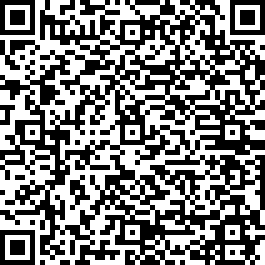

In [19]:
import qrcode
from IPython.display import Image 

qr = qrcode.QRCode(version=1, box_size=5, border=0)
qr.add_data(url)
qr.make(fit=True)

img = qr.make_image(fill='black', back_color='white')
qr_filename = 'qr-{0}.png'.format(ikof)
img.save(qr_filename)

Image(qr_filename)